<a href="https://colab.research.google.com/github/dsevero/phd-thesis/blob/main/PhD_Thesis_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%bash
sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
pip install SciencePlots

sudo: a terminal is required to read the password; either use the -S option to read from standard input or configure an askpass helper
sudo: a password is required


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.0/245.0 KB 8.5 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp39-cp39-macosx_11_0_arm64.whl (66 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 9.1 MB/s eta 0:00:00


You should consider upgrading via the '/Users/dsevero/phd-thesis/.venv/bin/python -m pip install --upgrade pip' command.


In [3]:
%%writefile custom.mplstyle
# Use LaTeX for math formatting
mathtext.fontset: dejavusans
font.family: serif
font.serif: computer modern roman
font.size: 12

Writing custom.mplstyle


# fig-optimal-code-uniform-source.tex

Matplotlib is building the font cache; this may take a moment.


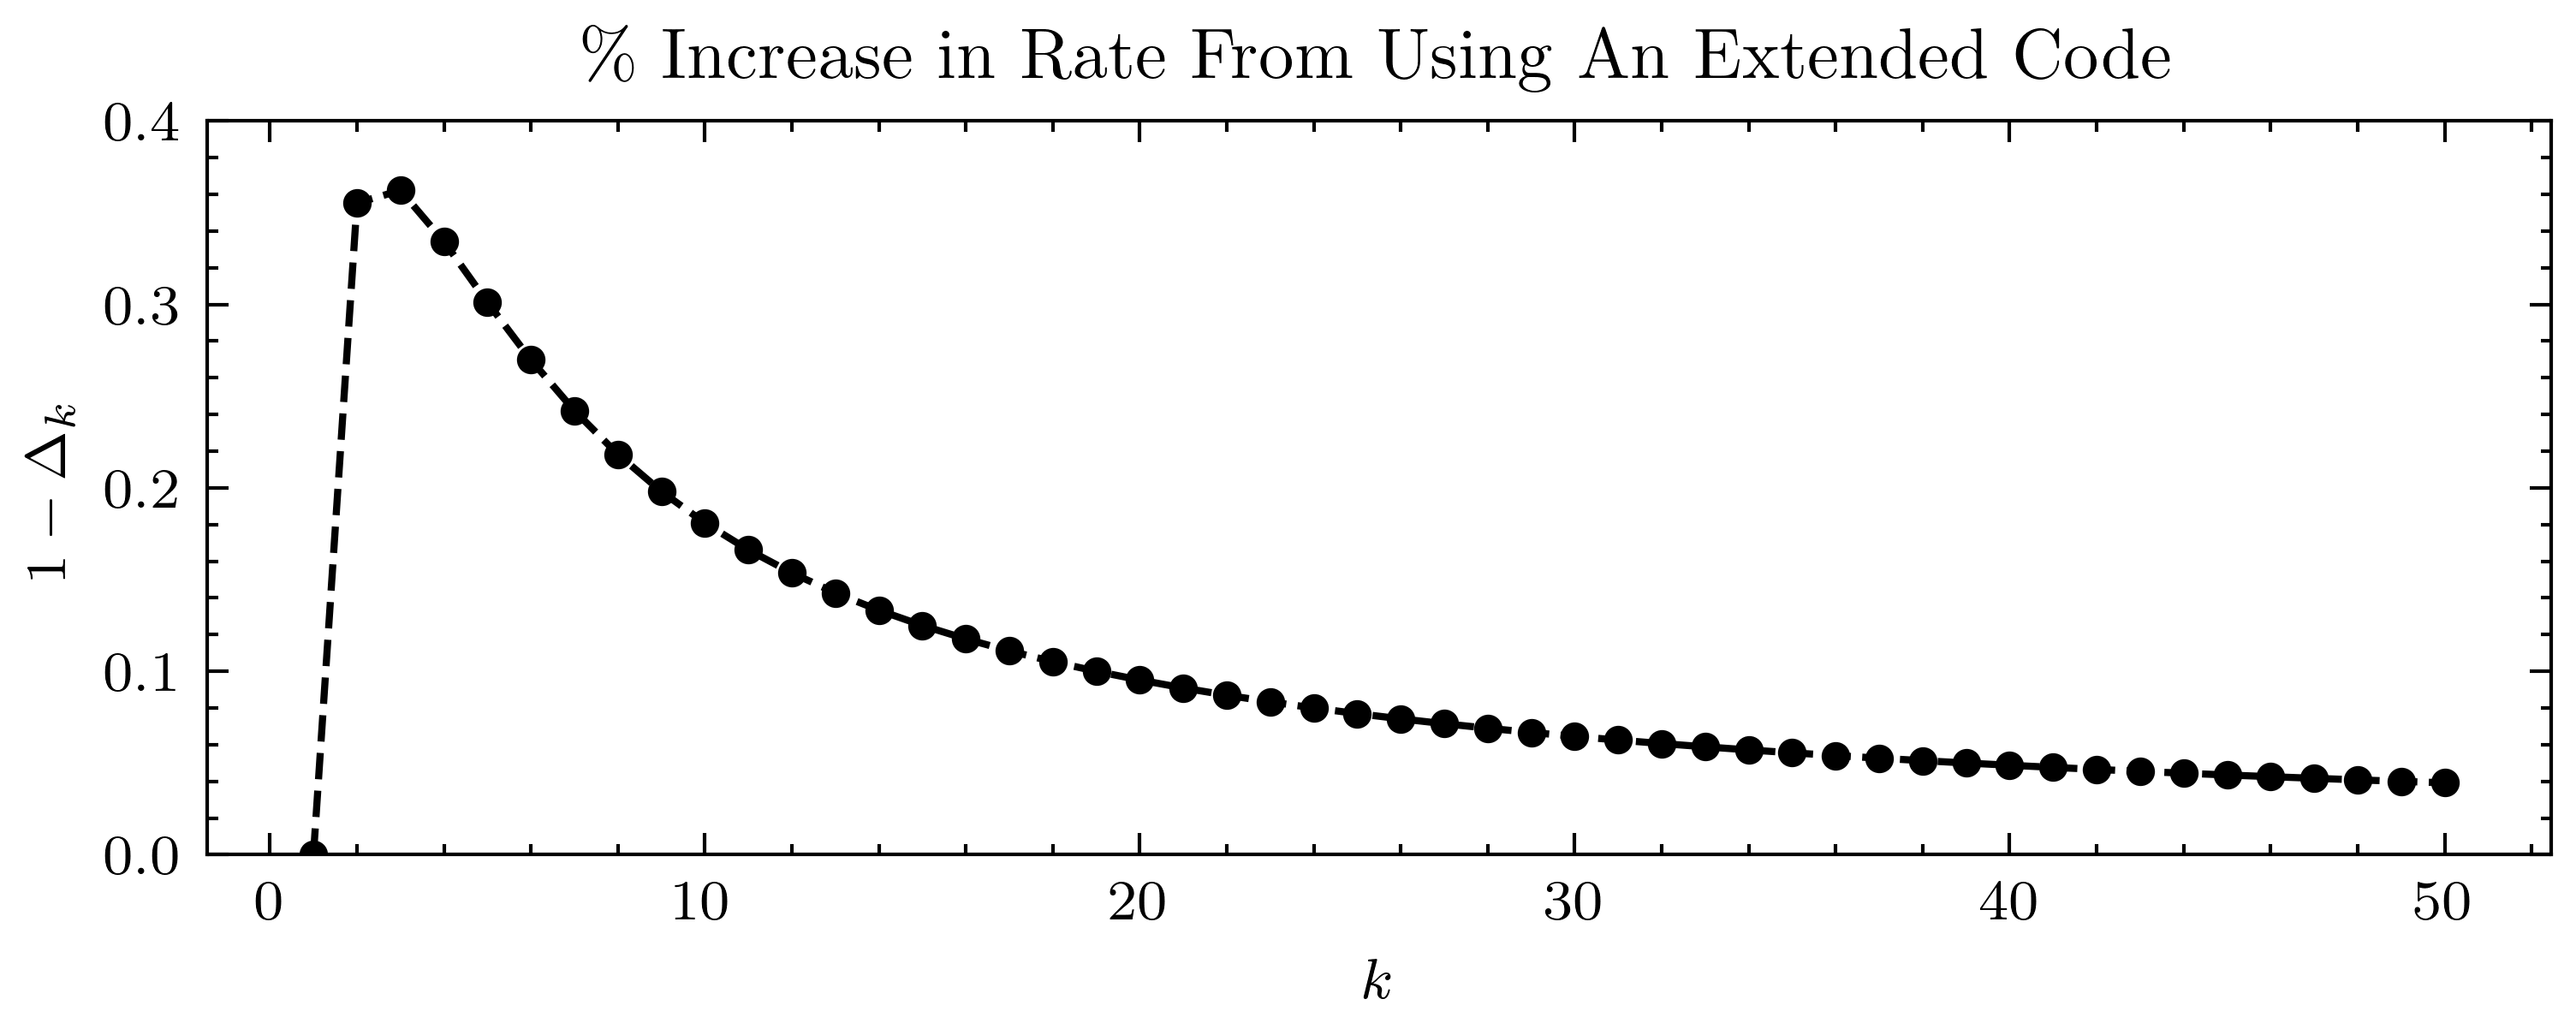

In [4]:
import math
import matplotlib.pyplot as plt
import numpy as np
import scienceplots


k_space = range(1, 50 + 1)
n = [math.log2(2*(2**k - 1))/8 for k in k_space]
delta_k = [(k*(2**k)-2**k + 1)/((2**k - 1)*math.log2(2*(2**k-1))) for k in k_space]

k_space = np.array(k_space)
n = np.array(n)
delta_k = np.array(delta_k)
with plt.style.context(['science', 'ieee', 'custom.mplstyle']):
    # Bit savings plot
    # fig, axes = plt.subplots(1, len(num_elements_sweep), figsize=(10, 2))
    fig, axes = plt.subplots(1, 1, figsize=(5, 2), sharex=False, sharey=False, layout='constrained')
    ax = axes
    ax.plot(k_space, 1 - delta_k, '.--')

    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)
    # ax.set_title(f'$n={num_elements}$', fontsize=8)

    #ax.set_xticks([1, 5, 10])
    #ax.set_yticks((10 + 5*np.arange(6))/10)
    ax.set_ylabel(r'$1 - \Delta_k$', fontsize=8)
    ax.set_ylim((0, 0.4))
    ax.set_xlabel(r'$k$', fontsize=8)
    ax.set_title('\% Increase in Rate From Using An Extended Code', fontsize=10)


    # plt.autoscale(tight=True)
    fig.savefig('fig-optimal-code-uniform-source.pdf')
    plt.show()

In [5]:
k_space = range(1, 1_000 + 1)
n = [math.log2(2*(2**k - 1))/8 for k in k_space]
delta_k = [(k*(2**k)-2**k + 1)/((2**k - 1)*math.log2(2*(2**k-1))) for k in k_space]

k_space = np.array(k_space)
n = np.array(n)
delta_k = np.array(delta_k)

i_th = np.argmax((1 - delta_k < 0.01)[1:])
n[i_th]

np.float64(25.0)

# ANS

In [6]:
from functools import reduce
from collections import Counter

def push(s, x, forward_lookup, N):
    p, c = forward_lookup(x)
    return N*(s // p) + (s % p) + c

def pop(s, reverse_lookup, N):
    j = s % N
    x, p, c = reverse_lookup(j)
    return x, p*(s // N) + j - c

def make_lookup_funcs(freqs):
    precision = sum(freqs)
    alphabet = range(len(freqs))
    qcdf = reduce(lambda acc, el: acc + [acc[-1] + el], freqs, [0])[:-1]

    def forward_lookup(x):
        return freqs[x], qcdf[x]

    def reverse_lookup(j):
        for x in alphabet:
            p = freqs[x]
            c = qcdf[x]
            if c <= j < c + p:
                return x, p, c

    return forward_lookup, reverse_lookup

def _test_rans():
    freqs = [2, 4, 4]
    forward_lookup, reverse_lookup = make_lookup_funcs(freqs)
    N = sum(freqs)

    # Some symbols to compress
    sequence = 1*[2, 0, 0, 1]

    # Encode
    s = 1
    for x in reversed(sequence):
        s = push(s, x, forward_lookup, N)

    # Decode
    decoded_sequence = list()
    for i in range(len(sequence)):
        x, s = pop(s, reverse_lookup, N)
        decoded_sequence.append(x)

    # Sanity checks
    assert decoded_sequence == sequence
    print('All tests passed.')

_test_rans()

freqs = [2, 4, 4]
alphabet = range(len(freqs))
forward_lookup, reverse_lookup = make_lookup_funcs(freqs)
N = sum(freqs)
states = [1 << 10000]

symbols = list()
while states[-1] > 0:
    x, s = pop(states[-1], reverse_lookup, N)
    symbols.append(x)
    states.append(s)

counts = Counter(symbols)
n = sum(counts.values())
print([(c, round(c/n, 2)) for c in counts.values()])


for s in [0, 1, 2, 3]:
    print(s)
    for x in alphabet:
        s = push(s, x, forward_lookup, N)
        print(s, x)

All tests passed.
[(2587, 0.4), (2612, 0.4), (1347, 0.21)]
0
0 0
2 1
8 2
1
1 0
3 1
9 2
2
10 0
24 1
66 2
3
11 0
25 1
67 2
